In [1]:
import numpy as np
import pandas as pd
from optimization import compute_dists, compute_full_l2_dists
from data import load_data, to_relative
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from adjustText import adjust_text
import seaborn as sns
import umap

# matplotlib svg
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# sns paper
sns.set_context("paper")

/Users/pierreadorni/Documents/capabilities-embedding/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tasks Analysis

In [2]:
coords = np.load('results/optim_params.npy')
n_dimensions = 5
n_cols = 92
vec_coords = np.reshape(coords, (-1, n_dimensions))
cols = vec_coords[:n_cols]
rows = vec_coords[n_cols:]

cols.shape, rows.shape

((92, 5), (45, 5))

In [3]:
dists = compute_dists(coords, n_cols, n_dimensions)
dists.shape

(45, 92)

In [4]:
data = load_data()
data.shape

(85, 160)

In [5]:
# create a df that is the same as the original data, but with the distances as the values
df = pd.DataFrame(dists, index=data.index, columns=data.columns)
print(df['Potsdam mf1']['ViT-B IN'])

ValueError: Shape of passed values is (45, 92), indices imply (85, 160)

In [6]:
df.index

NameError: name 'df' is not defined

In [7]:
tasks_info = pd.read_csv('tasks.csv', index_col=0)
tasks_info.head()

,task
Dataset,
Dyna.-Pla,segmentation
Dyna.-S2 seg,segmentation
BEN-MM,classification
PASTIS-MM,segmentation
PASTIS-HD classif,classification


In [8]:
def find_parent_task(task):
    for t in tasks_info.index:
        if task.startswith(t):
            return t
    return None

In [9]:
task_types = [tasks_info['task'][find_parent_task(task)] for task in data.columns]

In [10]:
reducer = umap.UMAP(metric="precomputed", n_neighbors=100, min_dist=0)
dists = compute_full_l2_dists(coords, n_dimensions)
optim_coords = reducer.fit_transform(dists)

/Users/pierreadorni/Documents/capabilities-embedding/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/pierreadorni/Documents/capabilities-embedding/venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


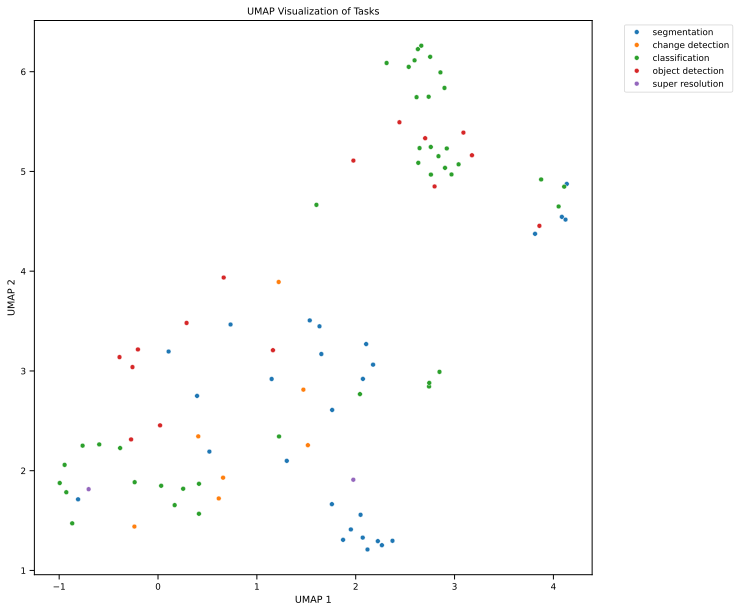

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

# parent_task_to_children = {}
# for child in data.columns:
#     parent = find_parent_task(child)
#     if parent not in parent_task_to_children:
#         parent_task_to_children[parent] = []
#     parent_task_to_children[parent].append(child)

# for parent, children in parent_task_to_children.items():
#     idx = [data.columns.get_loc(c) for c in children]
#     sns.scatterplot(x=optim_coords[idx, 0], y=optim_coords[idx, 1], ax=ax)
# plt.show()

# create a scatter plot with hue being the task type
sns.scatterplot(x=optim_coords[:n_cols, 0], y=optim_coords[:n_cols, 1], hue=task_types, ax=ax)

# improve the plot appearance
plt.title('UMAP Visualization of Tasks')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

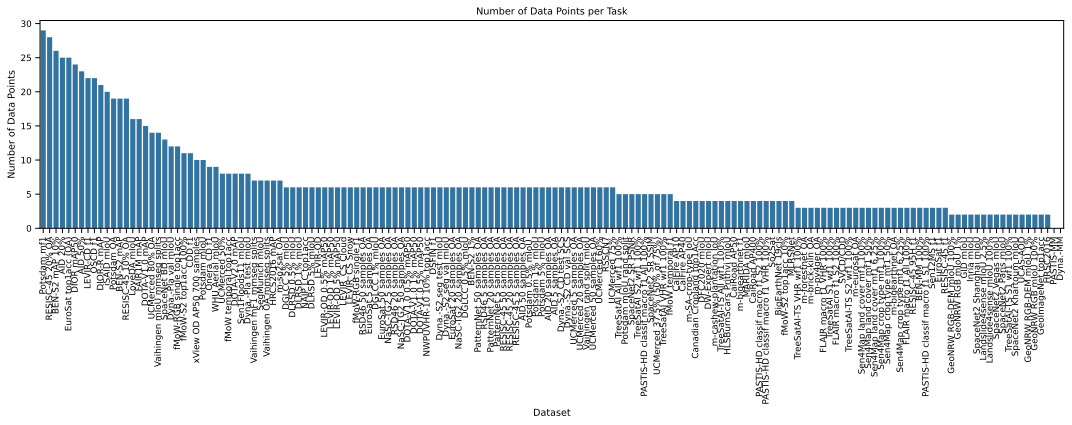

In [11]:
# sort data by count
data = data.reindex(data.count().sort_values(ascending=False).index, axis=1)
plt.figure(figsize=(15, 6))
sns.barplot(x=data.columns, y=data.count())
plt.xticks(rotation=90)
plt.xlabel('Dataset')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per Task')
plt.tight_layout()
plt.show()

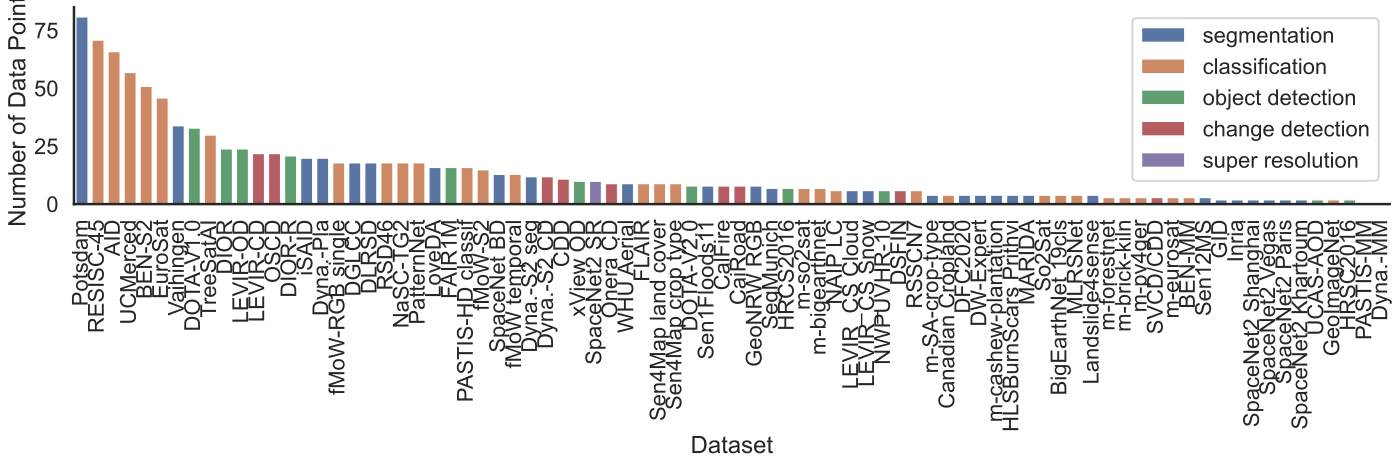

In [12]:
# same but group by parent task
parent_task_to_children = {}
for child in data.columns:
    parent = find_parent_task(child)
    if parent not in parent_task_to_children:
        parent_task_to_children[parent] = []
    parent_task_to_children[parent].append(child)

parent_task_to_count = {parent: sum(data[child].count() for child in children) for parent, children in parent_task_to_children.items()}
parent_task_to_count = {k: v for k, v in sorted(parent_task_to_count.items(), key=lambda item: item[1], reverse=True)}

parent_task_types = [tasks_info['task'][parent] for parent in parent_task_to_count.keys()]

sns.set_theme(style="white")
sns.set_context("poster")
plt.figure(figsize=(20, 7))
sns.barplot(x=list(parent_task_to_count.keys()), y=list(parent_task_to_count.values()), hue=parent_task_types)
sns.despine()
plt.xticks(rotation=90)
plt.xlabel('Dataset')
plt.ylabel('Number of Data Points')
plt.tight_layout()
plt.savefig('plots/datasets_usage.pdf', bbox_inches='tight')
plt.show()

manque de downstream tasks radar, hyperspectral
il y a un peu de multitemp mais pas beaucoup

nous on s'intéresse aux vision models

tableau: 
 - meilleur modèle par dataset
 - meilleur low-cost model
 - sensor
 - group by task type
 - indicateur de difficulté
         

In [13]:
np.unique(parent_task_types, return_counts=True)

(array(['change detection', 'classification', 'object detection',
        'segmentation', 'super resolution'], dtype='<U16'),
 array([ 9, 30, 11, 31,  1]))

In [14]:
9+30+11+31+1

82

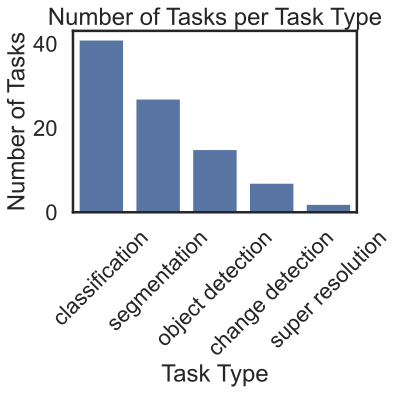

In [20]:
# same but per task type
task_type_to_count = {}
for task_type in task_types:
    if task_type not in task_type_to_count:
        task_type_to_count[task_type] = 0
    task_type_to_count[task_type] += 1

task_type_to_count = {k: v for k, v in sorted(task_type_to_count.items(), key=lambda item: item[1], reverse=True)}


plt.figure(figsize=(6, 6))
sns.barplot(x=list(task_type_to_count.keys()), y=list(task_type_to_count.values()))
plt.xticks(rotation=45)
plt.xlabel('Task Type')
plt.ylabel('Number of Tasks')
plt.title('Number of Tasks per Task Type')
plt.tight_layout()
plt.show()

In [16]:
task_type_to_count

NameError: name 'task_type_to_count' is not defined

# Models analysis

In [17]:
models_info = pd.read_csv('data/models.csv', index_col=0)
models_info.head()

,Architecture,Parameters (M),Publication Date
Model,,,
GeoKR,ResNet50,24.0,05/10/2021
ResNet50 IN,ResNet50,24.0,NaN
ResNet18 IN,ResNet18,11.0,NaN
WRN-50-2 IN,WRN-50-2,68.9,NaN
MoCo,ResNet50,24.0,13/11/2019


In [18]:
# set "Publication Date" column to datetime
models_info["Publication Date"] = pd.to_datetime(models_info["Publication Date"], format='%d/%m/%Y')
# if the publication date is NaN, set it to be the minimum date
models_info['Publication Date'] = models_info['Publication Date'].fillna(models_info['Publication Date'].min())
models_info.head()

,Architecture,Parameters (M),Publication Date
Model,,,
GeoKR,ResNet50,24.0,2021-10-05
ResNet50 IN,ResNet50,24.0,2019-11-13
ResNet18 IN,ResNet18,11.0,2019-11-13
WRN-50-2 IN,WRN-50-2,68.9,2019-11-13
MoCo,ResNet50,24.0,2019-11-13


In [19]:
# Compute mean distance for each model (row)
mean_distances = df.mean(axis=1)

# Add mean distances to models_info
models_info['Mean Distance'] = mean_distances

# remove the models that have NaN values
# models_info = models_info.dropna()

# Display result
print(models_info.head())

NameError: name 'df' is not defined

In [20]:
plt.figure(figsize=(10, 6), dpi=130)
sns.scatterplot(data=models_info, x='Parameters (M)', y='Mean Distance', hue='Architecture')
plt.title('Mean Distance vs Parameters')
# legend is outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

ValueError: Could not interpret value `Mean Distance` for `y`. An entry with this name does not appear in `data`.

<Figure size 1300x780 with 0 Axes>

In [21]:
gt_data = load_data()
# convert the data to relative (the function returns a np array so only set the values of the df)
gt_data.values[:] = to_relative(gt_data.values)
gt_data.head()

,Dyna.-Pla test mIoU,Dyna.-Pla val mIoU,Dyna.-S2 seg val mIoU,Dyna.-S2 seg test mIoU,BEN-MM 100%,PASTIS-MM,PASTIS-HD classif macro f1 VHR 100%,PASTIS-HD classif macro f1 S2 100%,PASTIS-HD classif macro f1 S1 100%,PASTIS-HD classif macro f1 All 100%,...,TreeSatAI-TS All wf1 100%,m-eurosat OA,Landslide4sense mIoU 100%,Landslide4sense mIoU 2.5%,Sen4Map land cover mf1 100%,Sen4Map land cover mf1 50%,"Sen4Map land cover mf1 6,25%",Sen4Map crop type mf1 100%,Sen4Map crop type mf1 50%,"Sen4Map crop type mf1 6,25%"
GeoKR,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ResNet50 IN,NaN,NaN,NaN,NaN,0.333333,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
ResNet18 IN,NaN,0.556709,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WRN-50-2 IN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MoCo,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
architecture_types = {
    'ResNet50': 'CNN',
    'ResNet34': 'CNN',
    'ResNet18': 'CNN',
    'WRN-50-2': 'CNN',
    'ViT-S': 'Transformer',
    'ViT-B': 'Transformer',
    'ViT-L': 'Transformer',
    'ViT-H': 'Transformer',
    'ViT-G': 'Transformer',
    'ViT-e': 'Transformer',
    'Swin-T': 'Transformer',
    'Swin-S': 'Transformer',
    'Swin-B': 'Transformer',
    'Swin-L': 'Transformer',
    'Swin-H': 'Transformer',
    'ViTAE-B': 'Transformer',
    'ConvNext-B': 'CNN',
    'ViTAEv2-S': 'Transformer',
    'InternImageXL': 'CNN',
    'ConvNextV2-Atto': 'CNN',
    'OmniSat-Conv': 'CNN',
    'ViT-AnySat': 'Transformer',
}

models_info['Architecture Type'] = models_info['Architecture'].map(architecture_types)
models_info.head()

,Architecture,Parameters (M),Publication Date,Architecture Type
Model,,,,
GeoKR,ResNet50,24.0,2021-10-05,CNN
ResNet50 IN,ResNet50,24.0,2019-11-13,CNN
ResNet18 IN,ResNet18,11.0,2019-11-13,CNN
WRN-50-2 IN,WRN-50-2,68.9,2019-11-13,CNN
MoCo,ResNet50,24.0,2019-11-13,CNN


80


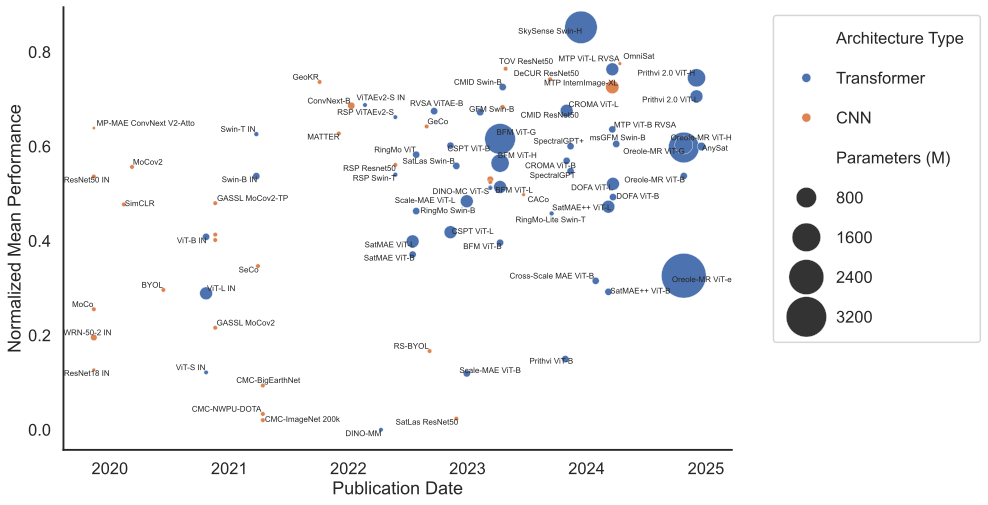

In [30]:
gt_mean_distances = gt_data.mean(axis=1)
models_info['GT Mean Distance'] = 1-gt_mean_distances

# order the models by their parameters
models_info = models_info.sort_values('Parameters (M)', ascending=False)

sns.set_context("talk")
plt.figure(figsize=(12, 8), dpi=200)
scatter = sns.scatterplot(data=models_info, x='Publication Date', y='GT Mean Distance', hue='Architecture Type', size='Parameters (M)', sizes=(10, 2000))

# count the number of points that were plotted
# since we used a date as a x-axis, we don't have an actual float x value to use for adjust_text. 
# print the x values computed by matplotlib from the date
# Get the x values of the plotted points
x_values = [p.get_offsets()[:,0] for p in scatter.collections][0]
y_values = [p.get_offsets()[:,1] for p in scatter.collections][0]
# Create a list to store the Text objects
texts = []

print(len(x_values))

unauthorized_models = ["GASSL MoCoV2-Geo","GASSL MoCov2-TP+Geo", "DINO-MC WRN-50-2", "DINO-MC ResNet50", "DINO-MC Swin-T"]

# Add labels for each point
for idx, row in models_info.iterrows():
    if pd.isna(row['GT Mean Distance']):  # Only add labels for points with valid data
        continue
    if idx in unauthorized_models:
        continue
    text = plt.text(row['Publication Date'], row['GT Mean Distance'], 
                idx, 
                ha= 'center',
                va= 'center',
                fontsize=8)
    texts.append(text)

# Use adjust_text with objects parameter and better formatting
adjust_text(texts, 
            x=x_values,
            y=y_values,
            force_objects=(2, 2)
           )

sns.despine()
plt.ylabel("Normalized Mean Performance")

# plt.legend(loc='lower left', frameon=True, labelspacing=1.5, borderpad=1, mode="expand", ncol=8)
# put the legend below the chart
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', frameon=True, labelspacing=1.5, borderpad=1)
plt.savefig('plots/models_overview.pdf', bbox_inches='tight')
plt.show()


In [24]:
models_info.shape

(85, 5)